# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Business Understanding

The purpose of this project is to build and evaluate different models that predict whether or not a customer will respond to an offer (binary classification). In addition, it would be important to know what are the main features that have an influence on the success of an offer. 

# Data understanding

In [1]:
# import relevant libaries
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Portfolio data

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
# Count number of rows
print("The number of rows for the portfolio data is: " + str(f"{portfolio.shape[0]}"))

The number of rows for the portfolio data is: 10


In [4]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


There are two informational offers which give 0 Dollars reward. All other offers give rewards between 2 and 10 dollars.

In [5]:
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


## Profile data

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
print("The number of rows for the profile data is: " + str(f"{profile.shape[0]}"))

The number of rows for the profile data is: 17000


In [9]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [10]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


Max age (118) is very high. The average income (62.531)/ median income (58.000) indicates that most Starbucks customers belong to the middle class.

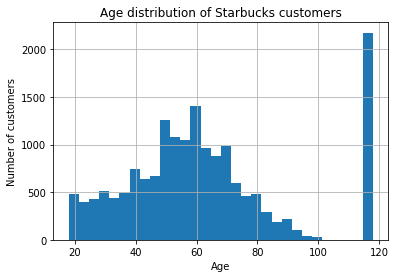

In [11]:
profile.age.hist(bins = 30)
plt.xlabel('Age')
plt.ylabel('Number of customers')
plt.title('Age distribution of Starbucks customers');

From the plot, we can see that more than 2.000 customers are 118 years old - which cannot be possible. Data cleaning is required for this data (see data preparation).

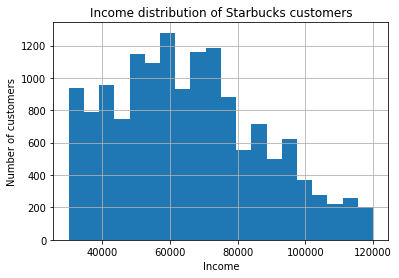

In [12]:
profile.income.hist(bins = 20);
plt.xlabel('Income')
plt.ylabel('Number of customers')
plt.title('Income distribution of Starbucks customers');

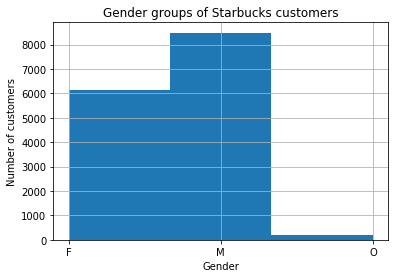

In [13]:
profile.gender.hist(bins = 3);
plt.xlabel('Gender')
plt.ylabel('Number of customers')
plt.title('Gender groups of Starbucks customers');

Most of the customer are males. We can also see that some customers have the value 'O' for other rather than M or F.

## Transcript data

In [14]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [15]:
print("The number of rows for the transcript data is: " + str(f"{transcript.shape[0]}"))

The number of rows for the transcript data is: 306534


In [16]:
transcript.dtypes

event     object
person    object
time       int64
value     object
dtype: object

In [17]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


# Data preparation

## Portfolio data

In [18]:
# Rename column
portfolio = portfolio.rename({'id': 'offer_id'}, axis=1)
portfolio.head(10)

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [19]:
# get dummy variables for channels and offer_type
# see also: https://stackoverflow.com/questions/47026585/unhashable-type-list-error-with-get-dumies
# see also: https://www.learndatasci.com/glossary/dummy-variable-trap/
channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack(), prefix='channel', prefix_sep='_',).sum(level=0)
offer_type = pd.get_dummies(portfolio.offer_type.apply(pd.Series).stack(), prefix='offer_type', prefix_sep='_',).sum(level=0)
portfolio = pd.concat([portfolio, channels, offer_type], axis=1)

In [20]:
# Remove channels column
portfolio.drop(['channels'], axis=1, inplace=True)

In [21]:
# Remove column channel email since it appears in all rows
portfolio.drop(['channel_email'], axis=1, inplace=True)

In [22]:
# Check for duplicates
portfolio.duplicated().sum()

0

In [23]:
# Check for nan values
portfolio.isna().sum()

difficulty                  0
duration                    0
offer_id                    0
offer_type                  0
reward                      0
channel_mobile              0
channel_social              0
channel_web                 0
offer_type_bogo             0
offer_type_discount         0
offer_type_informational    0
dtype: int64

In [24]:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,0,1,0


## Profile data

In [25]:
# Rename column
profile = profile.rename({'id': 'customer_id'}, axis=1)

In [26]:
# Convert became_member_on_ from int to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [27]:
# Check for duplicates
profile.duplicated().sum()

0

In [28]:
# handle outliers (see data understanding)
profile.query('age == 118')

,age,became_member_on,gender,customer_id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,2016-11-22,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,2017-08-24,None,c4863c7985cf408faee930f111475da3,NaN
11,118,2015-09-19,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,2017-08-01,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,2017-09-07,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


From the data, we can see that all for all persons aged 118, also gender and income is NaN. We therefore remove these outliers from our data.

In [29]:
# Remove outliers
profile.drop(index=profile.query('age == 118').index, inplace=True)

In [30]:
# Check if gender and income nan values are removed
profile.isna().sum()

age                 0
became_member_on    0
gender              0
customer_id         0
income              0
dtype: int64

In [31]:
# get dummy variables for gender
gender = pd.get_dummies(profile.gender.apply(pd.Series).stack(), prefix='gender', prefix_sep='_', drop_first=True).sum(level=0)
profile = pd.concat([profile, gender], axis=1)

In [32]:
# add column member_since (in days)
today = datetime.datetime.today().date()
profile['member_since'] = (today - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date).dt.days

In [33]:
profile.head()

,age,became_member_on,gender,customer_id,income,gender_M,gender_O,member_since
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,1459
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,1526
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,1,0,1174
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,1,0,1250
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1,0,1340


## Transcript data

In [34]:
# Rename column
transcript = transcript.rename({'person': 'customer_id'}, axis=1)
transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [35]:
# convert time from hours to days
transcript['time'] = transcript['time'] / 24

In [36]:
# get dummy variables for event
event = pd.get_dummies(transcript.event.apply(pd.Series).stack(), prefix='event', prefix_sep='_').sum(level=0)
transcript = pd.concat([transcript, event], axis=1)
transcript.head()

,event,customer_id,time,value,event_offer completed,event_offer received,event_offer viewed,event_transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0


In [37]:
# extract unique keys from column value - serve as input name for new columns
key_list = []
for row in transcript.itertuples():    
    key = row.value.keys()
    for k in list(key):
        key_list.append(k)   
unique_value_list = list(set(key_list))
unique_value_list    

['offer_id', 'reward', 'amount', 'offer id']

In [38]:
# Replace key name "offer id" with "offer_id"
for row in transcript.itertuples():    
    if "offer id" in row.value.keys():
        row.value["offer_id"] = row.value.pop("offer id")
unique_value_list.remove('offer id')

In [39]:
for col in unique_value_list:  
    # add new columns to transcript
    transcript[col] = np.nan
    transcript[col] = transcript['value'].apply(lambda x: x[col] if col in x else np.nan)

In [40]:
# Remove value column
transcript.drop(['value'], axis=1, inplace=True)

In [41]:
# Check for duplicates
transcript.duplicated().sum()

397

In [42]:
# remove ducplicates
transcript = transcript.drop_duplicates(keep='first')

In [43]:
transcript.head()

,event,customer_id,time,event_offer completed,event_offer received,event_offer viewed,event_transaction,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [44]:
# calculate amount spent during offer (see time of offer received + duration), 
# amount spent before offer (between end of prev and beginnning of current offer),
# amount spent after offer (between end of current offer and beginning of next offer)
transcript = transcript.sort_values(by=['customer_id', 'time'], ascending=True)
transcript_portfolio = transcript.merge(portfolio, on='offer_id', how='left')
output_data = []

for index, row in transcript_portfolio.iterrows():
    if row['event'] == 'offer received':
        time_offer_valid_from = row['time']
        time_offer_valid_until = row['time'] + row['duration']
        output_data.append([row['customer_id'],row['offer_id'], 0, 0, 0, time_offer_valid_from, time_offer_valid_until])
    if row['event'] == 'transaction':
        offer_found = False
        for res in reversed(output_data):# an amount of a transaction can belong to several offers 
        # # res[5] = time_offer_valid_from; res[6] = time_offer_valid_until
            if res[5] <= math.floor(row['time']) and res[6] >= math.floor(row['time']): 
                res[3] = res[3] + row['amount']# res[3] = amount_spent_within
                offer_found = True
            else:
                if not offer_found:
                    res[4] = res[4] + row['amount'] # res[4] = amount_spent_after
                break
                
transcript_portfolio = pd.DataFrame(output_data, columns=['customer_id', 'offer_id', 'amount_spent_before', 'amount_spent_within', 'amount_spent_after', 'time_offer_valid_from', 'time_offer_valid_until'])
transcript_portfolio.head(10)

,customer_id,offer_id,amount_spent_before,amount_spent_within,amount_spent_after,time_offer_valid_from,time_offer_valid_until
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,22.16,0.00,7.0,10.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,8.57,0.00,14.0,18.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,22.68,0.00,17.0,22.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,96.87,0.00,21.0,31.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,69.20,0.00,24.0,31.0
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,0.70,3.39,7.0,12.0
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,0.00,0.00,24.0,29.0
7,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,0.00,13.49,0.0,4.0
8,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,0,11.93,0.00,7.0,14.0
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0,0.00,0.00,14.0,17.0


In [45]:
# amount before offer  = amount spent after offer of prev element 
transcript_portfolio['amount_spent_before'] = transcript_portfolio['amount_spent_after'].shift(1)
transcript_portfolio['amount_spent_before'] = transcript_portfolio['amount_spent_before'].fillna(0)
transcript_portfolio.head(10)

,customer_id,offer_id,amount_spent_before,amount_spent_within,amount_spent_after,time_offer_valid_from,time_offer_valid_until
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.00,22.16,0.00,7.0,10.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.00,8.57,0.00,14.0,18.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0.00,22.68,0.00,17.0,22.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0.00,96.87,0.00,21.0,31.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.00,69.20,0.00,24.0,31.0
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.70,3.39,7.0,12.0
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,3.39,0.00,0.00,24.0,29.0
7,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.00,0.00,13.49,0.0,4.0
8,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,13.49,11.93,0.00,7.0,14.0
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0.00,0.00,0.00,14.0,17.0


In [46]:
# compare calculation with original transcript dataframe for this customer
transcript.loc[transcript['customer_id'] == '78afa995795e4d85b5d9ceeca43f5fef']

,event,customer_id,time,event_offer completed,event_offer received,event_offer viewed,event_transaction,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.25,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,5.50,0,0,0,1,NaN,NaN,19.89
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.50,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,6.00,0,0,0,1,NaN,NaN,17.78
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,7.00,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,9.00,0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,9.25,0,0,0,1,NaN,NaN,19.67
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,10.00,0,0,0,1,NaN,NaN,29.72
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,15.75,0,0,0,1,NaN,NaN,23.93


In [47]:
transcript_portfolio.loc[transcript_portfolio['customer_id'] == '78afa995795e4d85b5d9ceeca43f5fef']

,customer_id,offer_id,amount_spent_before,amount_spent_within,amount_spent_after,time_offer_valid_from,time_offer_valid_until
35822,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,37.67,0.00,0.0,7.0
35823,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,0.00,49.39,23.93,7.0,10.0
35824,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,23.93,48.28,0.00,17.0,24.0
35825,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0.00,48.28,0.00,21.0,26.0


In [48]:
# Calculate if offer was successful = customer received, viewed and completed offer
transcript_new = transcript.groupby(['customer_id', 'offer_id'], as_index=False)['event_offer completed', 'event_offer received', 'event_offer viewed', 'reward'].agg('sum')
transcript_new.head()

,customer_id,offer_id,event_offer completed,event_offer received,event_offer viewed,reward
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,2.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,2.0


In [49]:
transcript_new.loc[transcript_new['event_offer completed'] > 1].head()

,customer_id,offer_id,event_offer completed,event_offer received,event_offer viewed,reward
14,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,2,2,1,4.0
22,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,2,2,2,4.0
31,004c5799adbf42868b9cff0396190900,f19421c1d4aa40978ebb69ca19b0e20d,2,2,2,10.0
32,004c5799adbf42868b9cff0396190900,fafdcd668e3743c1bb461111dcafc2a4,2,2,2,4.0
48,00715b6e55c3431cb56ff7307eb19675,0b1e1539f2cc45b7b9fa7c272da2e1d7,2,2,1,10.0


There are also cases, where a customer took the offer for more than 1 time. We assume that is allowed according to the terms of use.

In [50]:
# A customer completed a offer successfully (column offer_successful) if he/she received, viewed and completed the offer at least one time.
# Do not take customers into account who have received the offer and the completed the offer, but never actually viewed it
transcript_new['offer_successful'] = np.where((transcript_new['event_offer received'] > 0) & (transcript_new['event_offer viewed'] > 0) & (transcript_new['event_offer completed'] > 0), 1, 0)
transcript_new.head()

,customer_id,offer_id,event_offer completed,event_offer received,event_offer viewed,reward,offer_successful
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,2.0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0.0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0.0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5.0,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,2.0,1


In [51]:
# drop not relevant columns
transcript_new = transcript_new.drop(columns=['event_offer completed', 'event_offer received', 'event_offer viewed'])
transcript_new.head()

,customer_id,offer_id,reward,offer_successful
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2.0,1


## Merge all dataframes

In [52]:
# merge the transcript dataframe with the portfolio dataframe 
merged_df = transcript_new.merge(transcript_portfolio, how='left', on=['customer_id', 'offer_id'])
merged_df.head()

,customer_id,offer_id,reward,offer_successful,amount_spent_before,amount_spent_within,amount_spent_after,time_offer_valid_from,time_offer_valid_until
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,0,0.0,69.20,0.0,24.0,31.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,0,0.0,8.57,0.0,14.0,18.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,0,0.0,22.16,0.0,7.0,10.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0.0,22.68,0.0,17.0,22.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,0.0,96.87,0.0,21.0,31.0


In [53]:
merged_df = merged_df.drop(columns=['time_offer_valid_until', 'time_offer_valid_from'])
merged_df.head()

,customer_id,offer_id,reward,offer_successful,amount_spent_before,amount_spent_within,amount_spent_after
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,0,0.0,69.20,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,0,0.0,8.57,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,0,0.0,22.16,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0.0,22.68,0.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,0.0,96.87,0.0


In [54]:
# total money spent before/during/after offer for both groups (offer_successful)
df = merged_df[['offer_successful','amount_spent_before', 'amount_spent_within', 'amount_spent_after']]
df = df.groupby(['offer_successful']).sum()
df

,amount_spent_before,amount_spent_within,amount_spent_after
offer_successful,,,
0,96971.40,608408.33,118252.61
1,92534.86,1638565.81,71253.65


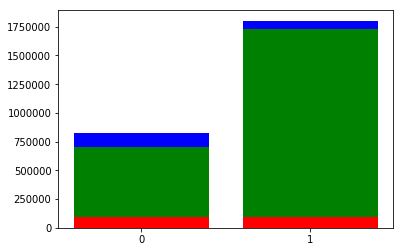

In [55]:
import matplotlib.pyplot as plt
  
x = list(map(str, df.index))
y_before = list(df.amount_spent_before)
y_within = list(df.amount_spent_within)
y_after = list(df.amount_spent_after)

 
plt.bar(x, y_before, color='r')
plt.bar(x, y_within, bottom=y_before, color='g')
plt.bar(x, y_after, bottom=np.array(y_before)+np.array(y_within), color='b')
plt.show()

Customers who have successfully participated in the offer spend in total almost twice (1.802.354,32) as much as customers who have not successfully participated in the offer (823.632,34).
It seems to be that giving customers an offer is very profitable for Starbucks!

In [56]:
# remove amount_spent_within and amount_spent_after since we do not have the data at the time we want to start a new offer and predict which customers might respond to an offer
merged_df = merged_df.drop(columns=['amount_spent_within', 'amount_spent_after'])
merged_df.head()

,customer_id,offer_id,reward,offer_successful,amount_spent_before
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,0,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,0,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,0.0


In [57]:
# merge with Profile data
merged_df = merged_df.merge(profile, how='left', on=['customer_id'])
merged_df.head()

,customer_id,offer_id,reward,offer_successful,amount_spent_before,age,became_member_on,gender,income,gender_M,gender_O,member_since
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,0,0.0,33.0,2017-04-21,M,72000.0,1.0,0.0,1544.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,0,0.0,33.0,2017-04-21,M,72000.0,1.0,0.0,1544.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,0,0.0,33.0,2017-04-21,M,72000.0,1.0,0.0,1544.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0.0,33.0,2017-04-21,M,72000.0,1.0,0.0,1544.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,0.0,33.0,2017-04-21,M,72000.0,1.0,0.0,1544.0


In [58]:
merged_df = merged_df.drop(columns=['became_member_on', 'gender'])
merged_df.head()

,customer_id,offer_id,reward,offer_successful,amount_spent_before,age,income,gender_M,gender_O,member_since
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,0,0.0,33.0,72000.0,1.0,0.0,1544.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,0,0.0,33.0,72000.0,1.0,0.0,1544.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,0,0.0,33.0,72000.0,1.0,0.0,1544.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0.0,33.0,72000.0,1.0,0.0,1544.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,0.0,33.0,72000.0,1.0,0.0,1544.0


In [59]:
# merge with Portfolio data
merged_df = merged_df.merge(portfolio, how='left', on=['offer_id'])
merged_df.head()

,customer_id,offer_id,reward_x,offer_successful,amount_spent_before,age,income,gender_M,gender_O,member_since,difficulty,duration,offer_type,reward_y,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,0,0.0,33.0,72000.0,1.0,0.0,1544.0,10,7,discount,2,1,0,1,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,0,0.0,33.0,72000.0,1.0,0.0,1544.0,0,4,informational,0,1,0,1,0,0,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,0,0.0,33.0,72000.0,1.0,0.0,1544.0,0,3,informational,0,1,1,0,0,0,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0.0,33.0,72000.0,1.0,0.0,1544.0,5,5,bogo,5,1,1,1,1,0,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,0.0,33.0,72000.0,1.0,0.0,1544.0,10,10,discount,2,1,1,1,0,1,0


In [60]:
df = merged_df[['offer_successful','offer_type']]
df = df.groupby(['offer_successful', 'offer_type']).size().to_frame(name = 'size').reset_index()
df

,offer_successful,offer_type,size
0,0,bogo,15560
1,0,discount,14697
2,0,informational,15235
3,1,bogo,14939
4,1,discount,15846


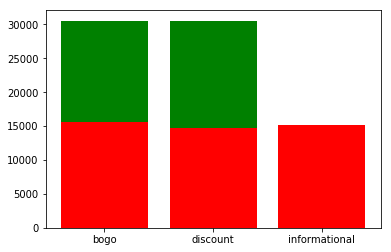

In [61]:
# display offer_successful by offertype

import matplotlib.pyplot as plt
  
x = list(df.offer_type.unique())
y0 = list(df[df.offer_successful == 0]['size'])
y1 = list(df[df.offer_successful == 1]['size'])
y1.append(0)
 
plt.bar(x, y0, color='r')
plt.bar(x, y1, bottom=y0, color='g')
plt.show()

There are no successful informational offers (informational offers are never completed since they have no reward). We delete them from the dataset

In [62]:
merged_df = merged_df.drop(merged_df[merged_df.offer_type == 'informational'].index)
merged_df = merged_df.drop(columns=['offer_type_informational'])  

In [63]:
merged_df = merged_df.drop(columns=['offer_type', 'duration', 'difficulty', 'reward_x', 'reward_y'])
merged_df.head()

,customer_id,offer_id,offer_successful,amount_spent_before,age,income,gender_M,gender_O,member_since,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,0.00,33.0,72000.0,1.0,0.0,1544.0,1,0,1,0,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,0.00,33.0,72000.0,1.0,0.0,1544.0,1,1,1,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,0.00,33.0,72000.0,1.0,0.0,1544.0,1,1,1,0,1
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,0.00,NaN,NaN,NaN,NaN,NaN,1,1,1,1,0
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,3.39,NaN,NaN,NaN,NaN,NaN,1,1,1,1,0


In [64]:
merged_df.columns

Index(['customer_id', 'offer_id', 'offer_successful', 'amount_spent_before',
       'age', 'income', 'gender_M', 'gender_O', 'member_since',
       'channel_mobile', 'channel_social', 'channel_web', 'offer_type_bogo',
       'offer_type_discount'],
      dtype='object')

In [65]:
# check for nan values
merged_df.isnull().sum()

customer_id               0
offer_id                  0
offer_successful          0
amount_spent_before       0
age                    7841
income                 7841
gender_M               7841
gender_O               7841
member_since           7841
channel_mobile            0
channel_social            0
channel_web               0
offer_type_bogo           0
offer_type_discount       0
dtype: int64

In [66]:
merged_df[merged_df['age'].isna()].head()

,customer_id,offer_id,offer_successful,amount_spent_before,age,income,gender_M,gender_O,member_since,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,0.00,NaN,NaN,NaN,NaN,NaN,1,1,1,1,0
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,3.39,NaN,NaN,NaN,NaN,NaN,1,1,1,1,0
48,0063def0f9c14bc4805322a488839b32,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0.00,NaN,NaN,NaN,NaN,NaN,0,0,1,0,1
49,0063def0f9c14bc4805322a488839b32,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0.00,NaN,NaN,NaN,NaN,NaN,1,1,1,0,1
51,0063def0f9c14bc4805322a488839b32,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.00,NaN,NaN,NaN,NaN,NaN,1,0,1,1,0


In [67]:
# delete all nan values, since we have no profile data
merged_df = merged_df.dropna()

## Data Modeling

In [68]:
from sklearn.model_selection import train_test_split

X = merged_df.drop(['customer_id', 'offer_id', 'offer_successful'], axis=1)
y = merged_df['offer_successful']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 37240 samples.
Testing set has 15961 samples.


In [109]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def model_results (model_name, y_test, model_pred):
    print('Classification Report of ' + model_name + ':')
    print(classification_report(y_test, model_pred))
    print("Overall accuracy:\t {}".format(accuracy_score(y_test, model_pred))) 
    # https://machinelearningmastery.com/fbeta-measure-for-machine-learning/ 
    # F2-measure puts more attention on minimizing false negatives
    # it has the effect of lowering the importance of precision and increase the importance of recall.  
    print("F2-Score:\t {}".format(fbeta_score(y_test, model_pred, beta=2.0)))  
    CM = confusion_matrix(y_test, model_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    print("TP, FP, TN, FN: ")
    print(TP, FP, TN, FN)
    sns.heatmap(CM,annot=True,fmt='d');
    plt.ylabel("Actual")
    plt.xlabel("Predicted");

In [107]:
import matplotlib.pyplot as plt
# see also
def print_feature_importance(feature_importance, X): 
    plt.rcdefaults()
    fig, ax = plt.subplots()
    features = (X.columns)
    y_pos = np.arange(len(features))
    ax.barh(y_pos, feature_importance, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    ax.invert_yaxis()
    ax.set_xlabel('Feature Importance')

Classification Report of Logistic Regression:
             precision    recall  f1-score   support

          0       0.90      0.86      0.88      7110
          1       0.89      0.93      0.91      8851

avg / total       0.90      0.90      0.90     15961

Overall accuracy:	 0.8963724077438757
F2-Score:	 0.9185710120876411
TP, FP, TN, FN: 
8192 995 6115 659


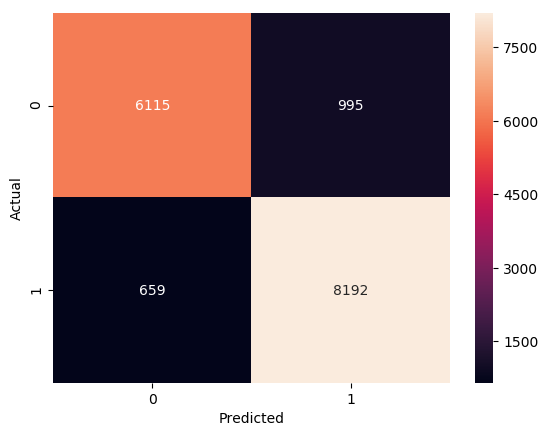

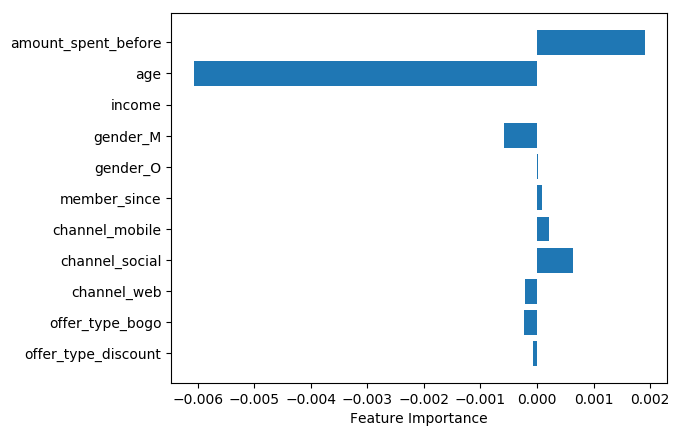

In [110]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr_pred = model.predict(X_test)
model_results ("Logistic Regression", y_test, lr_pred)
print_feature_importance (lr.coef_[0], X)

Souce: https://machinelearningmastery.com/calculate-feature-importance-with-python/

The positive scores indicate a feature that predicts class 1, 
whereas the negative scores indicate a feature that predicts class 0.

age is the most important feature to predict class 0.

amount_spent_before is the most important feature to predict class 1.

Classification Report of Random Forest Classifier:
             precision    recall  f1-score   support

          0       0.90      0.86      0.88      7110
          1       0.89      0.93      0.91      8851

avg / total       0.90      0.90      0.90     15961

Overall accuracy:	 0.8963724077438757
F2-Score:	 0.9185710120876411
TP, FP, TN, FN: 
8192 995 6115 659


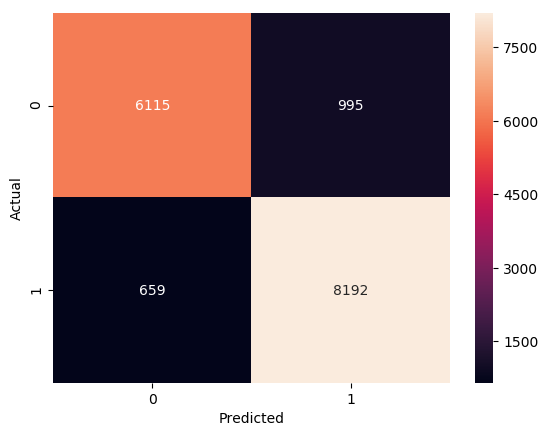

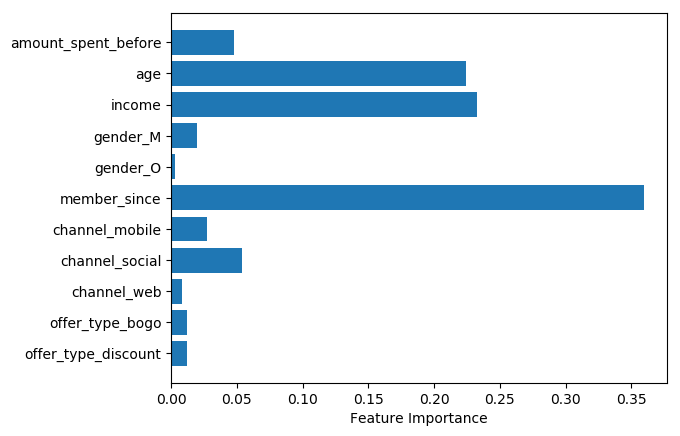

In [100]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, random_state=42)
rfc.fit(X_train, y_train)
rfc_pred = model.predict(X_test)
model_results ("Random Forest Classifier", y_test, rfc_pred)
print_feature_importance (rfc.feature_importances_, X)

member_since is the most important feature for prediction. 

Classification Report of AdaBoost Classifier:
             precision    recall  f1-score   support

          0       0.90      0.86      0.88      7110
          1       0.89      0.93      0.91      8851

avg / total       0.90      0.90      0.90     15961

Overall accuracy:	 0.8963724077438757
F2-Score:	 0.9185710120876411
TP, FP, TN, FN: 
8192 995 6115 659


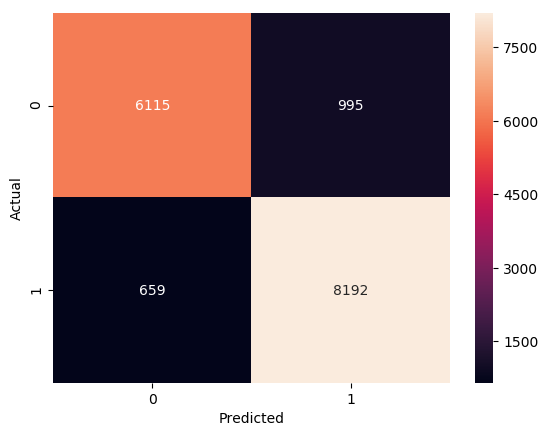

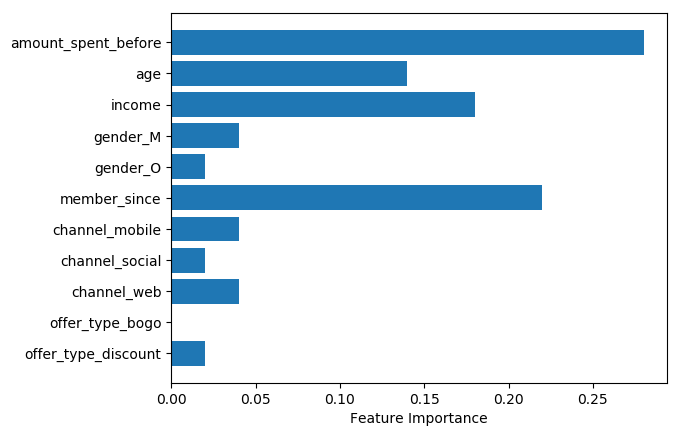

In [101]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(random_state=42)
abc.fit(X_train, y_train)
abc_pred = model.predict(X_test)
model_results ("AdaBoost Classifier", y_test, abc_pred)
print_feature_importance (abc.feature_importances_, X)

amount_spent_before is the most important feature for prediction. 

## Improving the model

### Balance dataset

In [74]:
# check for class balance in datasets
y.value_counts()

1    29511
0    23690
Name: offer_successful, dtype: int64

In [75]:
y_train.value_counts()

1    20660
0    16580
Name: offer_successful, dtype: int64

In [76]:
y_test.value_counts()

1    8851
0    7110
Name: offer_successful, dtype: int64

Nearly same amount of data for both groups (0: 56% 1: 44%); to balance the groups is thus not neccessary. However, we try it to see if we can improve the results. 

In [77]:
df_majority = merged_df[merged_df.offer_successful==0]
df_minority = merged_df[merged_df.offer_successful==1]

In [78]:
# downsample majority class (see: https://elitedatascience.com/imbalanced-classes)
from sklearn.utils import resample
df_majority_downsampled = resample(df_majority, replace=False, n_samples=23690, random_state=42)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled.offer_successful.value_counts()

1    29511
0    23690
Name: offer_successful, dtype: int64

In [79]:
X_bal = df_downsampled.drop(['customer_id', 'offer_id', 'offer_successful'], axis=1)
y_bal = df_downsampled['offer_successful']
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size = 0.3, random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train_bal.shape[0]))
print("Testing set has {} samples.".format(X_test_bal.shape[0]))

Training set has 37240 samples.
Testing set has 15961 samples.


In [80]:
# Balance check for train and test data
y_test_bal.value_counts()

1    8832
0    7129
Name: offer_successful, dtype: int64

In [81]:
y_train_bal.value_counts()

1    20679
0    16561
Name: offer_successful, dtype: int64

Classification Report of Logistic Regression:
             precision    recall  f1-score   support

          0       0.74      0.70      0.72      7129
          1       0.77      0.80      0.78      8832

avg / total       0.75      0.75      0.75     15961

Overall accuracy:	 0.7532736044107512
F2-Score:	 0.7906856578001438
TP, FP, TN, FN: 
7039 2145 4984 1793


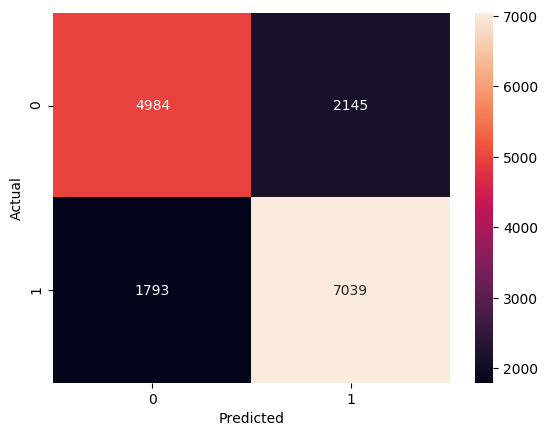

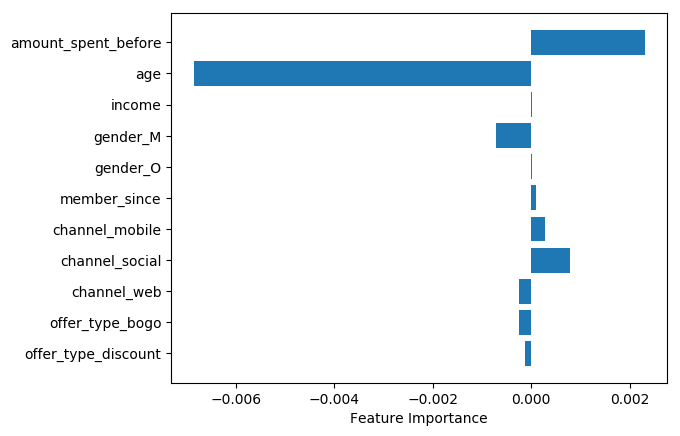

In [103]:
lr.fit(X_train_bal, y_train_bal)
lr_bal_pred = model.predict(X_test_bal)
model_results ("Logistic Regression", y_test_bal, lr_bal_pred)
print_feature_importance (lr.coef_[0], X_bal)

Classification Report of Random Forest Classifier:
             precision    recall  f1-score   support

          0       0.74      0.70      0.72      7129
          1       0.77      0.80      0.78      8832

avg / total       0.75      0.75      0.75     15961

Overall accuracy:	 0.7532736044107512
F2-Score:	 0.7906856578001438
TP, FP, TN, FN: 
7039 2145 4984 1793


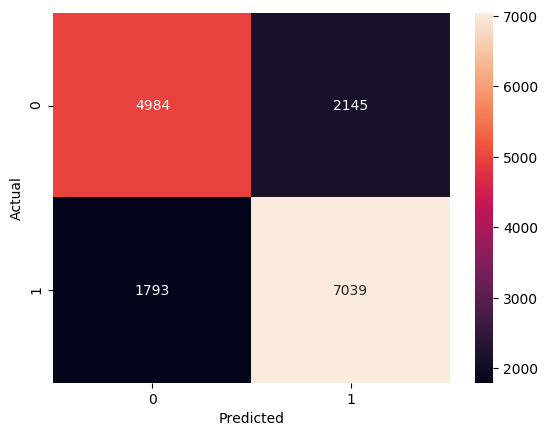

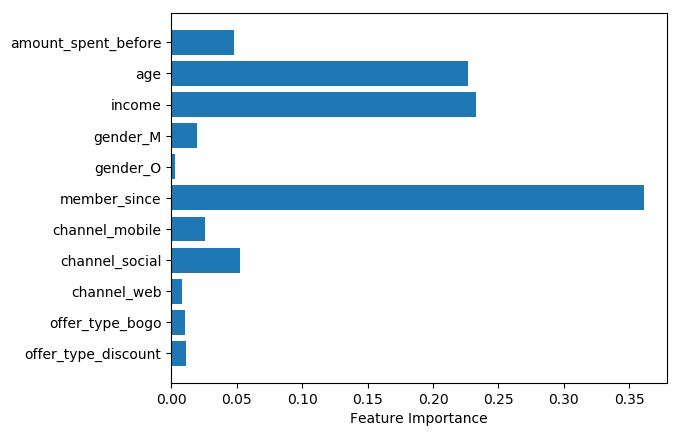

In [104]:
rfc.fit(X_train_bal, y_train_bal)
rfc_bal_pred = model.predict(X_test_bal)
model_results ("Random Forest Classifier", y_test_bal, rfc_bal_pred)
print_feature_importance (rfc.feature_importances_, X_bal)

Classification Report of AdaBoost Classifier:
             precision    recall  f1-score   support

          0       0.74      0.70      0.72      7129
          1       0.77      0.80      0.78      8832

avg / total       0.75      0.75      0.75     15961

Overall accuracy:	 0.7532736044107512
F2-Score:	 0.7906856578001438
TP, FP, TN, FN: 
7039 2145 4984 1793


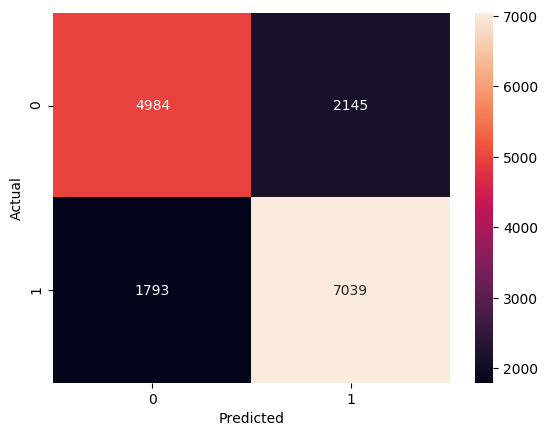

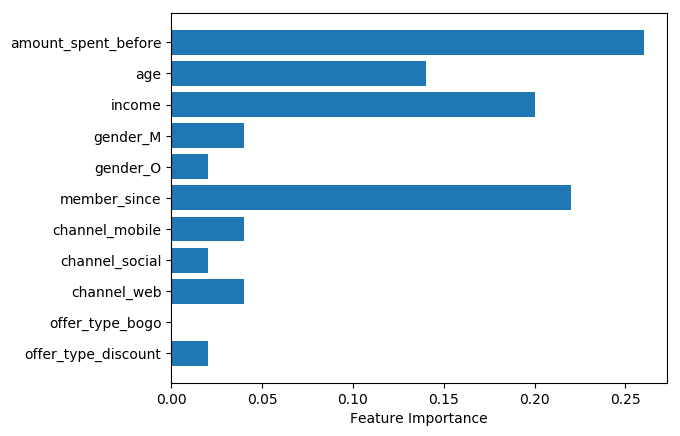

In [105]:
abc.fit(X_train_bal, y_train_bal)
abc_bal_pred = model.predict(X_test_bal)
model_results ("AdaBoost Classifier", y_test_bal, abc_bal_pred)
print_feature_importance (abc.feature_importances_, X_bal)

### Correlation matrix

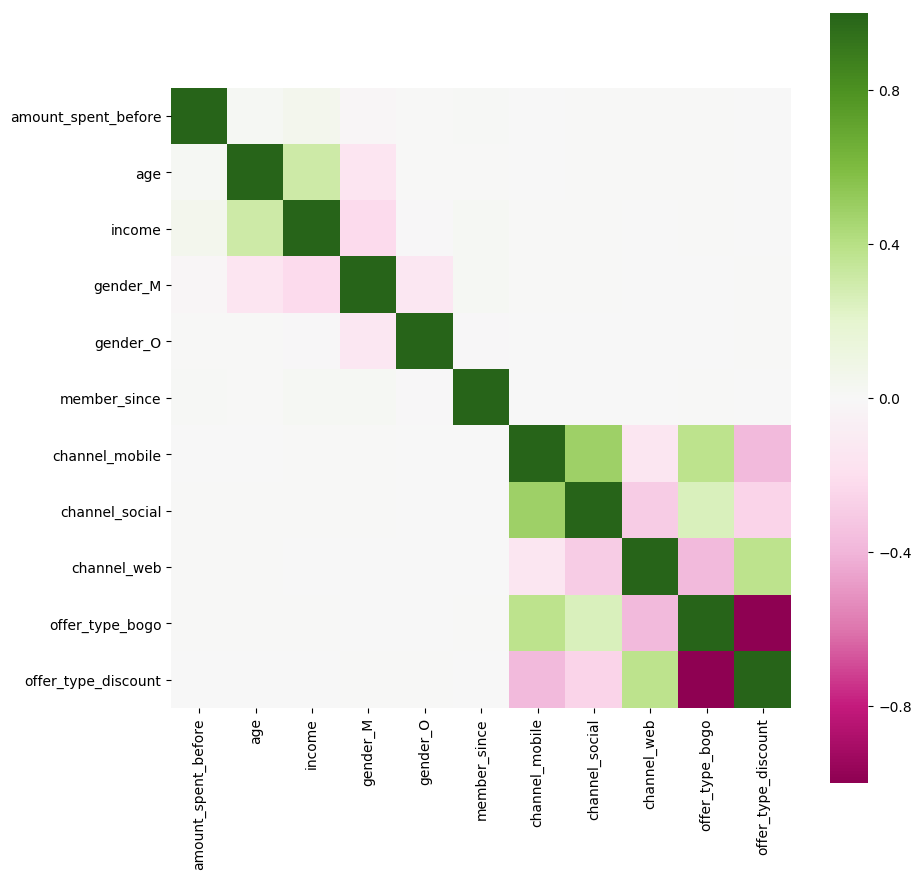

In [85]:
plt.figure(figsize=(10,10))
sns.heatmap(X.corr(),square=True, cmap='PiYG');

Results of the correlation matrix looks good. Only bogo and discount seems to be highly correlated. You might split the dataset into these two offertypes and perform the prediction again.

### Parameter tuning

In [92]:
# As logistic regression does not have any critical hyperparameters to tune, I've decided to tune the second best classifier, the Random Forest Classifier
from sklearn.model_selection import GridSearchCV

grid_search = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10,25,50]}

model = GridSearchCV(estimator = rfc, param_grid = grid_search, cv = 4, verbose= 5, n_jobs = -1)
model.fit(X_train,y_train)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.7143163999570401, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.7075187969924812, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.7046186895810956, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.7112471801482436, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25 


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25, score=0.7196863924390506, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25, score=0.7068743286788399, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25, score=0.706766917293233, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25, score=0.7138253303254914, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=auto,

[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed: 39.0min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 30, 100], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [10, 25, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [93]:
print(model.best_params_)

{'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


Classification Report of Random Forest Classifier tuned:
             precision    recall  f1-score   support

          0       0.90      0.86      0.88      7110
          1       0.89      0.93      0.91      8851

avg / total       0.90      0.90      0.90     15961

Overall accuracy:	 0.8963724077438757
F2-Score:	 0.9185710120876411
TP, FP, TN, FN: 
8192 995 6115 659


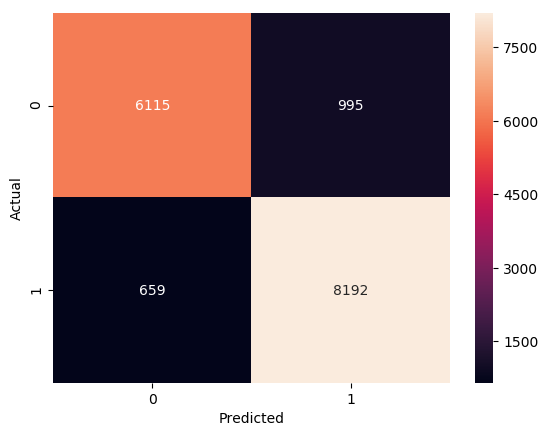

In [111]:
rfc_tuned_pred = model.best_estimator_.predict(X_test)
model_results ('Random Forest Classifier tuned', y_test, rfc_tuned_pred)

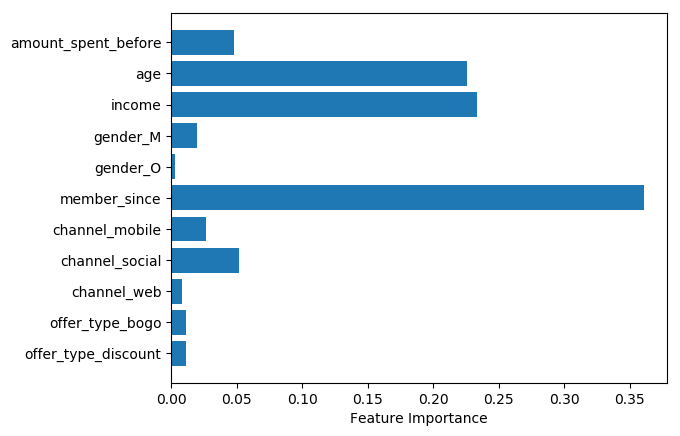

In [96]:
print_feature_importance (rfc.feature_importances_, X)

# Results

In this project, I've predicted the success of an offer based on customer data, transaction data, and portfolio data. In this case, the offer success is equal to 1 if a customer received, viewed and completed an offer in the past, othervise it is equal to 0. Since informational offers never showed a completed offer, I've removed this data. For modeling, I've built a simple classification model using Logistic Regression, Random Forest Classifier, and AdaBoost Classifier. I've tried to improve the model results by balancing the groups. As there were nearly the same amount of data for both groups initially (0: 56% 1: 44%), it was not surprising that there was only a slight increase in the model results. Additionally, I've tried to improve the Logistic Regression Model by using GridSearch for hyper tuning the parameters. 

| Model | Overall Accuracy | Precision | Recall | F1 Score | F2 Score | TP | FP | TN | FN | Feature importance
| :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- |
| Logistic Regression | 0.56 | 0.56 | 0.97 | 0.71 | 0.85 | 8596 | 6697 | 413 | 255 | age (class 0), amount_spent_before (class 1)
| Random Forest Classifier | 0.75 | 0.77 | 0.79 | 0.78 | 0.78 | 6945 | 2110 | 5000 | 1906 | member_since, income, age
| AdaBoost Classifier | 0.69 | 0.70 | 0.77 | 0.73 | 0.75 | 6785 | 2857 | 4253 | 2066 | amount_spent_before, member_since, income
| Logistic Regression balanced | 0.56 | 0.56 | 0.99 | 0.71 | 0.86 | 8696 | 6846 | 283 | 136 | age (class 0), amount_spent_before (class 1)
| Random Forest Classifier balanced | 0.76 | 0.77 | 0.80 | 0.78 | 0.79 | 7029 | 2082 | 5047 | 1803 | member_since, income, age
| AdaBoost Classifier balanced | 0.69 | 0.70 | 0.77 | 0.74  | 0.76 | 6816 | 2875 | 4254 | 2016 | amount_spent_before, member_since, income
| Random Forest Classifier tuned |














# Evaluation

In this use case, our goal is to reduce the number of false negatives and increase the number of true positives. The reason for this is, that customers who took an offer spent twice as money as customers who do not take an offer. As sending an offer via app is not expensive for Starbucks, the number of true negatives is not of high relevance in our case.

While looking at the results, I would go for the balanced Logistic Regression model. Although, its accuracy is the lowest of all models, its recall value (0.97) and F2 Score (0.86) is the highest. I've used these two metrics for evaluation as they focus on false negatives and true positives. 

For calculation, I've used the following formulars:

- Overall accuracy = (TP + TN) / (TP + TN + FP + FN)
- Precision (Specificity) = TP / (TP + FP) 
- Recall (Sensitivity) = TP / (TP + FN) 
- F1 Score = (2 * precision * recall) / (precision + recall)        --- Balance the weight on precision and recall
- F2 Score = (5 * precision * recall) / (4 * precision + recall)    --- Less weight on precision, more weight on recall


# Future work

For future work, we can try the following steps to further improve our model:
- Try out other algorithms such as support vector machines or neural networks
- Combine the results of several models together 
- Split the input data into bogo and discount and perform prediction on both offer types
- Do more parameter tuning
- Focus more on feature engineering (e.g., combine features and include more features, if available)
- instead of removing missing values, impute them

Moreover, we should filter out the money savers. However additional information would be required: how much money does a customer need to spent within an offer, so that Starbucks still makes profit.

In [ ]:
def input, output definieren

werte der tabelle stimmen nicht mehr

feature importance unterschied? --> oder nes reg model???

import nach oben ziehen++

komentare lesen und ergänzen